### LOAD AND PLOT DATA FROM A SESSION #### 
This notebook should run from within the iblenv.
The functions are taken from the source code of the IBL library. 

For documentation check:

https://int-brain-lab.github.io/iblenv/_autosummary/ibllib.io.raw_data_loaders.html?highlight=raw%20data%20loaders#module-ibllib.io.raw_data_loaders



In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# @Author: Mora Ogando
# @Date: Sunday, July 4th 2021, 1:28:46 pm
"""

Raw Data Loader functions for PyBpod rig

Module contains one loader function per raw datafile
"""
#import things
import json
import logging
import wave
from datetime import datetime
from pathlib import Path
from typing import Union
import matplotlib.pyplot as plt

import itertools
from glob import glob
import pickle

import numpy as np
import pandas as pd
import utils as ut

#from ibllib.io import jsonable
from ibllib.io import raw_data_loaders
# from ibllib.misc import version
# Helpers Mori

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def appendColumnToDF(df,OneDArray,columnName,appendTO):
# the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.
    # 1. create a pandas series with your array
    series = pd.Series(list(OneDArray),name=columnName)
    # 2. create the index (has to match the index in "appendTO")
    index= pd.Series(np.arange(0,len(OneDArray)),name=appendTO)
    # 3. make a DataFrame with these 
    appendDF = pd.DataFrame(series,index)
    
    #4. join it onto a new dataframe
    try:
        df.reset_index(inplace=True)
    except:
        pass
    df2 = df.set_index([appendTO])
    df2 = df.join(appendDF,on=appendTO,how='left')
    return df2

def saveTrialWiseInfo_inServer(session_path):
    #Load data 
    session_data = raw_data_loaders.load_data(session_path)
    settings =raw_data_loaders.load_settings(session_path)
    encoder_events = raw_data_loaders.load_encoder_events(session_path, settings=False)
    encoder_positions =raw_data_loaders.load_encoder_positions(session_path, settings=False)
    encoder_trial_info = raw_data_loaders.load_encoder_trial_info(session_path)

    # correct responses is a boolean list of len = number of trials.


    # append correct responses to trial info

    # ((the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.))
    OneDArray = correct_responses
    columnName = 'correct'
    appendTO = 'trial_num'
    trialInfo= appendColumnToDF(encoder_trial_info,OneDArray,columnName,appendTO)

    # get the time in the same units and merge the encoder position with the trialInfo dataFrames
    trialInfo['relative_time_ms'] = (pd.to_datetime(trialInfo.bns_ts).values -pd.to_datetime(trialInfo.bns_ts).values[0])/1000000
    trialInfo['relative_time_ms'] = trialInfo.relative_time_ms.astype(np.int64) 
    encoder_positions['relative_time_ms'] = (encoder_positions.re_ts.values- encoder_positions.re_ts.values[0])/1000
    merged_df = pd.merge(trialInfo, encoder_positions, on = 'relative_time_ms',how='outer')

    # save

    name = 'behavior_analysis_df'

    merged_df.to_csv(path + name + '.csv')
    out_path = r'W:\Satsuma\Mora//' + path.split('C:\\')[-1]
    out_path 
    import os
    try:
        os.makedirs(out_path)
        print('created a new results folder')
    except:
        print('couldnt make folder')
        print(out_path)

    merged_df.to_csv(out_path + name + '.csv')
    trialInfo.to_csv(out_path + 'trialInfo.csv')
    return  merged_df,trialInfo

### Merge session info and save it in the server ###

In [2]:
session_path = ut.selectFolder()

2023-02-07 11:41:45.888 python[15007:14755434] +[CATransaction synchronize] called within transaction


In [3]:
subject = 'MBOT53_010'
date = '2022-07-23'
session = '002'

#Load data 
session_data = raw_data_loaders.load_data(session_path)
settings =raw_data_loaders.load_settings(session_path)
encoder_events = raw_data_loaders.load_encoder_events(session_path, settings=False)
encoder_positions =raw_data_loaders.load_encoder_positions(session_path, settings=False)
encoder_trial_info = raw_data_loaders.load_encoder_trial_info(session_path)


In [4]:
# correct responses is a boolean list of len = number of trials.
correct_responses = [session_data[i]['trial_correct'] for i in range(len(session_data))]
# append correct responses to trial info
# ((the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.))
OneDArray = correct_responses
columnName = 'correct'
appendTO = 'trial_num'
trialInfo= appendColumnToDF(encoder_trial_info,OneDArray,columnName,appendTO)

# # # get the time in the same units and merge the encoder position with the trialInfo dataFrames
# trialInfo['relative_time_ms'] = (pd.to_datetime(trialInfo.bns_ts).values -pd.to_datetime(trialInfo.bns_ts).values[0])/1000000
# trialInfo['relative_time_ms'] = trialInfo.relative_time_ms.astype(np.int64) 
# encoder_positions['relative_time_ms'] = (encoder_positions.re_ts.values- encoder_positions.re_ts.values[0])/1000
# merged_df = pd.merge(trialInfo, encoder_positions, on = 'relative_time_ms',how='outer')

In [5]:
session_data[30]['trial_num']

31

In [6]:
encoder_positions

,index,re_ts,re_pos
0,0,2.844960e+05,-17
1,1,2.891770e+05,-18
2,2,2.942520e+05,-19
3,3,3.006290e+05,-20
4,4,3.333450e+05,-19
...,...,...,...
247384,247384,2.551896e+09,4
247385,247385,2.551974e+09,5
247386,247386,2.551996e+09,6
247387,247387,2.553223e+09,5


In [7]:
only_contrasts_and_accuracy= trialInfo[["stim_contrast", "correct"]].dropna()
only_contrasts_and_accuracy['correct'] = only_contrasts_and_accuracy['correct'].astype('int')
only_contrasts_and_accuracy.groupby('stim_contrast').agg(np.mean)


,correct
stim_contrast,
1,0.613043


In [8]:
trialInfo

,index,trial_num,stim_pos_init,stim_contrast,stim_freq,stim_angle,stim_gain,stim_sigma,stim_phase,bns_ts,correct
0,0,1,1,1,0.06,-0.785398,2,10000,0.000000,2022-08-29T17:49:56.9594368-07:00,True
1,1,2,1,1,0.06,0.785398,2,10000,272.158450,2022-08-29T17:50:04.7949568-07:00,True
2,2,3,1,1,0.06,0.785398,2,10000,228.441988,2022-08-29T17:50:10.4958720-07:00,True
3,3,4,-1,1,0.06,-0.785398,2,10000,64.094365,2022-08-29T17:50:16.7637248-07:00,True
4,4,5,1,1,0.06,0.785398,2,10000,230.379303,2022-08-29T17:50:21.2978048-07:00,True
...,...,...,...,...,...,...,...,...,...,...,...
227,227,228,1,1,0.06,0.785398,2,10000,84.036052,2022-08-29T18:30:14.4667008-07:00,False
228,228,229,1,1,0.06,0.785398,2,10000,33.721887,2022-08-29T18:30:42.3395200-07:00,False
229,229,230,1,1,0.06,0.785398,2,10000,297.435996,2022-08-29T18:31:10.2107264-07:00,False
230,230,231,1,1,0.06,0.785398,2,10000,102.813875,2022-08-29T18:31:38.0673280-07:00,NaN


### Make behavior stim conditions to synchronize holography and pybpod ###

fraction correct for session was 0.6147186147186147
fraction correct for angle 0 = 0.71
fraction correct for angle 90 = 0.5419847328244275


(0.0, 1.0)

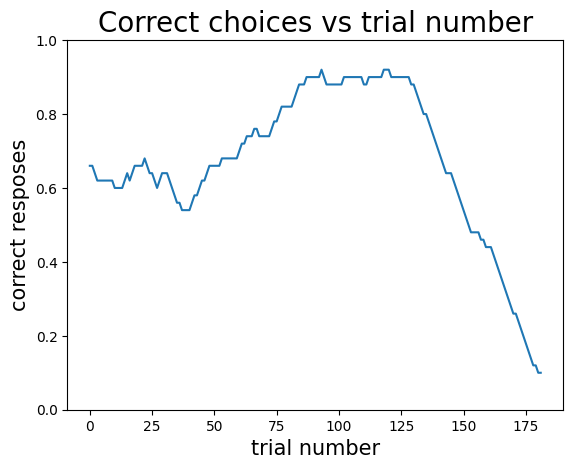

In [9]:
window = 50# how many trials to average 
firsttrial=0
lasttrial=4000
print('fraction correct for session ' + 'was ' + str(np.mean(correct_responses[:lasttrial])))
# get the info of which angle was shown at each trial 
stim_angle= [session_data[i]['stim_angle'] for i in range(len(session_data[:lasttrial]))]

deg90 = np.where(np.array(stim_angle)>0)[0][firsttrial:lasttrial] # array of trial numbers where the angle was more than 0
deg0= np.where(np.array(stim_angle)<=0)[0][firsttrial:lasttrial] # array of trial numbers where the angle was 0
correct90 = [correct_responses[i] for i in deg90]#@[firsttrial:lasttrial]
correct0 = [correct_responses[i] for i in deg0]#[firsttrial:lasttrial]

#get the % of correct responses for each angle across the whole session
print('fraction correct for angle 0 = ' + str(np.nanmean(correct0)))
print('fraction correct for angle 90 = ' + str(np.mean(correct90)))


# plot a moving average of the correct responses across trials for a given window
plt.plot(moving_average(correct_responses[firsttrial:lasttrial],window))
plt.title('Correct choices vs trial number',fontsize = 20)
plt.xlabel('trial number',fontsize = 15)
plt.ylabel('correct resposes',fontsize = 15)

plt.ylim(0,1)

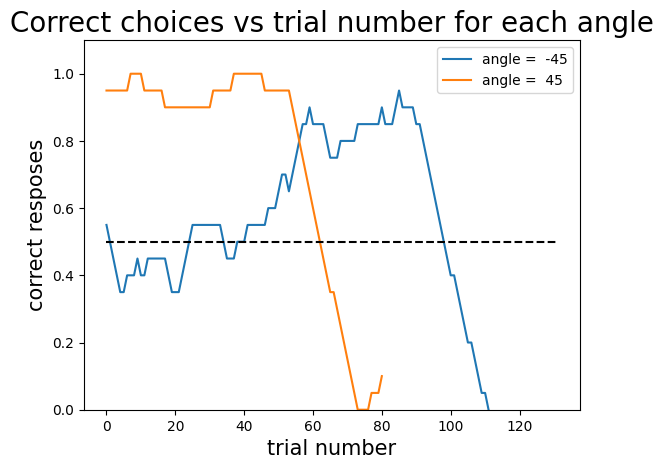

In [10]:
#plot % of correct responses for each angle across the whole session with a rolling average
# if correct responses are higher for one of the gratings, this indicates a bias.

window = 20
plt.plot(moving_average(correct90,window))
plt.plot(moving_average(correct0,window))
plt.title('Correct choices vs trial number for each angle',fontsize = 20)
plt.xlabel('trial number',fontsize = 15)
plt.ylabel('correct resposes',fontsize = 15)
plt.ylim(0,1.1)
xmax = max(len(correct90),len(correct0))
plt.hlines(0.5, 0, xmax, colors='black',linestyles='dashed')
plt.legend(['angle =  ' + str(i) for i in [-45,45]])
plt.savefig(session_path + '//Correct_vs_trial_per_angle')


In [11]:
session_path

'/Volumes/externalHD /test data/MBOT53_013/2022-08-29/001'

In [12]:
# compute the bias:

# bias computation for repeat_on_error on sessions
# %Left = ([N trials where angle presented was 0 & mouse was correct] + [N trials where angle presented was 90 and mouse was incorrect])/NtotalTrials
percent_left = (len(correct0) + (len(deg90)-len(correct90)))/(len(deg0)+len(deg90))
# Absolute bias = np.abs(0.5 - %Left)
abs_bias = np.abs(0.5 - percent_left)

# bias computation for repeat_on_error off sessions:

# bar chart of % abs bias
# categories = ['repeat_on_error on', 'repeat_on_error off']
# values = [abs_bias_on, abs_bias_off]
# plt.bar(categories, values)

print('Percent Left Choices:')
print(percent_left)
print('Percent Absolute Bias:')
print(abs_bias)

Percent Left Choices:
0.4329004329004329
Percent Absolute Bias:
0.0670995670995671


In [13]:
print(len(deg90))
print(len(deg0))

131
100


In [14]:
import math
math.pi/2

1.5707963267948966

In [ ]:
1*0.015

In [ ]:
0.25*0.05

In [ ]:
math.degrees(0.25*0.05)#%180

In [ ]:
math.degrees(0.25/0.05)%180